# Regression & Classification Model Implementation

In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, roc_curve, auc
from sklearn.utils import resample
from sklearn import datasets, linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor 

In [250]:
# Helper functions

def VIF(df, columns): 
    values=sm.add_constant(df[columns]).values
    # the dataframe passed to VIF␣ ↪ must include the intercept term. We add it the same way we did before. 
    num_columns=len(columns)+1#we added intercept 
    vif=[variance_inflation_factor(values, i) for i in range(num_columns)] 
    return pd.Series(vif[1:], index=columns)
def OSR2(model, y_train, x_test,y_test):
    y_pred=model.predict(x_test) 
    SSE=np.sum((y_test-y_pred)**2) 
    SST=np.sum((y_test-np.mean(y_train))**2) 
    return 1-(SSE/SST)
def avg_error(y_pred, y_test):
    return np.average(abs((y_pred - y_test) / y_test))
def get_metrics(y_predict, y_test):
    cm = confusion_matrix(y_test, y_predict)
    tn, fn, fp, tp = cm[0][0], cm[1][0], cm[0][1], cm[1][1]
    FPR = fp / (fp + tn)
    TPR = tp / (tp + fn)
    acc = (tp + tn) / (tp + tn + fp + fn)
    PRE = 0
    if (tp + fp != 0):
        PRE = tp / (tp + fp)
    return acc, TPR, FPR, PRE

## Load Data - Train & Test split with time benchmark

In [251]:
training_data = pd.read_csv('../features_train.csv')
training_data.drop(columns=['Unnamed: 0'], inplace=True)
training_data = training_data.drop(0)
training_data['Previous Sentiment'] = training_data['Sentiment'].shift(1)
training_data = training_data[1:]

testing_data = pd.read_csv('../features_test.csv')
testing_data.drop(columns=['Unnamed: 0'], inplace=True)
testing_data['Previous Sentiment'] = testing_data['Sentiment'].shift(1)

testing_data = testing_data[1:]
X_train = training_data.drop(columns=['Tesla Stock Close Price'])
y_train = training_data['Tesla Stock Close Price']
X_test = testing_data.drop(columns=['Tesla Stock Close Price'])
y_test = testing_data['Tesla Stock Close Price']

#use only the important features
features =X_train.columns
X_train.head()

,Tesla Stock Open Price,Tesla Stock Volume,Tesla Stock Adj Close Price,Tesla Stock High,Tesla Stock Low,S&P 500 Variance,Ford Stock Price,GM Stock Price,Toyota Stock Price,Nissan Stock Price,Tesla Wikipedia Page Views,Sentiment,Previous Sentiment,Previous Week Tesla Stock Close Price
2,1.401200,13199100.0,1.388933,1.424133,1.354267,435.732436,13.0400,34.189999,72.763998,15.460,1102.2,0.140323,0.089603,1.384800
3,1.256267,12649800.0,1.232667,1.264800,1.215600,380.825787,12.5600,34.189999,70.756001,15.062,898.0,0.040080,0.140323,1.388933
4,1.255867,7230300.0,1.261200,1.282000,1.233067,316.106150,12.0020,34.189999,70.690001,15.200,801.0,0.188023,0.040080,1.232667
5,1.303333,8167800.0,1.312267,1.333600,1.282933,591.345328,11.3280,34.189999,69.030000,14.992,766.2,0.168206,0.188023,1.261200
6,1.357833,6225000.0,1.385000,1.403833,1.351167,615.993610,11.7975,34.189999,69.000000,15.745,808.5,0.119400,0.168206,1.312267


## Linear Regression & Feature Engineering

In [252]:
#Now we want to see how the model behaves. We train the linear regression.
#We will mostly focus on the p-values, the VIF values, and R2.
X=X_train
Y=y_train
X2 = sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, features))

pd.set_option('display.max_colwidth', None) 

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       1.000
Model:                                 OLS   Adj. R-squared:                  1.000
Method:                      Least Squares   F-statistic:                 1.079e+20
Date:                     Sat, 04 May 2024   Prob (F-statistic):               0.00
Time:                             22:34:11   Log-Likelihood:                 7723.3
No. Observations:                      431   AIC:                        -1.542e+04
Df Residuals:                          416   BIC:                        -1.536e+04
Df Model:                               14                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [253]:
#We see that the p-values are very high for some features, we should eliminate them.
#We eliminate Tesla's Financial Features which are very correlated with the Close Price we are trying to predict, since it has a very high p-value as well as a high VIF value.
X_train = X_train.drop(columns=['Tesla Stock Open Price','Tesla Stock Adj Close Price','Tesla Stock High', 'Tesla Stock Low'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                     3759.
Date:                     Sat, 04 May 2024   Prob (F-statistic):               0.00
Time:                             22:34:11   Log-Likelihood:                -515.49
No. Observations:                      431   AIC:                             1053.
Df Residuals:                          420   BIC:                             1098.
Df Model:                               10                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [254]:
#Now we eliminate Nissan stock prices, since it has a very high p-value
X_train = X_train.drop(columns=['Nissan Stock Price'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                     4187.
Date:                     Sat, 04 May 2024   Prob (F-statistic):               0.00
Time:                             22:34:11   Log-Likelihood:                -515.49
No. Observations:                      431   AIC:                             1051.
Df Residuals:                          421   BIC:                             1092.
Df Model:                                9                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [255]:
#Now we eliminate  SP500 Variance , since it has a very high p-value
X_train = X_train.drop(columns=['S&P 500 Variance'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                     4721.
Date:                     Sat, 04 May 2024   Prob (F-statistic):               0.00
Time:                             22:34:11   Log-Likelihood:                -515.51
No. Observations:                      431   AIC:                             1049.
Df Residuals:                          422   BIC:                             1086.
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [256]:
#Now we eliminate Tesla Wikipedia Page Views, since it has a very high p-value
X_train = X_train.drop(columns=['Tesla Wikipedia Page Views'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                     5407.
Date:                     Sat, 04 May 2024   Prob (F-statistic):               0.00
Time:                             22:34:11   Log-Likelihood:                -515.58
No. Observations:                      431   AIC:                             1047.
Df Residuals:                          423   BIC:                             1080.
Df Model:                                7                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [257]:
#Now we eliminate Volume, since it has a very high p-value
X_train = X_train.drop(columns=['Tesla Stock Volume'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                     6307.
Date:                     Sat, 04 May 2024   Prob (F-statistic):               0.00
Time:                             22:34:11   Log-Likelihood:                -516.09
No. Observations:                      431   AIC:                             1046.
Df Residuals:                          424   BIC:                             1075.
Df Model:                                6                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [258]:
#Now we eliminate Sentiment scores, since it has a very high p-value
X_train = X_train.drop(columns=['Sentiment'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                     7570.
Date:                     Sat, 04 May 2024   Prob (F-statistic):               0.00
Time:                             22:34:12   Log-Likelihood:                -516.56
No. Observations:                      431   AIC:                             1045.
Df Residuals:                          425   BIC:                             1070.
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [259]:
#Now we eliminate GM stock prices, since it has a very high p-value
X_train = X_train.drop(columns=['GM Stock Price'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                     9443.
Date:                     Sat, 04 May 2024   Prob (F-statistic):               0.00
Time:                             22:34:12   Log-Likelihood:                -517.49
No. Observations:                      431   AIC:                             1045.
Df Residuals:                          426   BIC:                             1065.
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [260]:
#Now we eliminate Ford stock prices, since it has a very high p-value
X_train = X_train.drop(columns=['Ford Stock Price'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                 1.259e+04
Date:                     Sat, 04 May 2024   Prob (F-statistic):               0.00
Time:                             22:34:12   Log-Likelihood:                -518.06
No. Observations:                      431   AIC:                             1044.
Df Residuals:                          427   BIC:                             1060.
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

(63, 14)
R2 Score: 0.9725787708603995
OSR2 Score: 0.9922626917883026
   Toyota Stock Price  Previous Sentiment  \
1          141.020000            0.170538   
2          141.806000            0.092409   
3          141.556000            0.134267   
4          141.413998            0.231126   
5          138.842499            0.205790   

   Previous Week Tesla Stock Close Price  
1                              33.525466  
2                              35.679167  
3                              38.820533  
4                              51.983867  
5                              52.226400  
Mean Absolute Error: 10.098887378382408
Mean Absolute Error Percentage: 0.07143988072713697


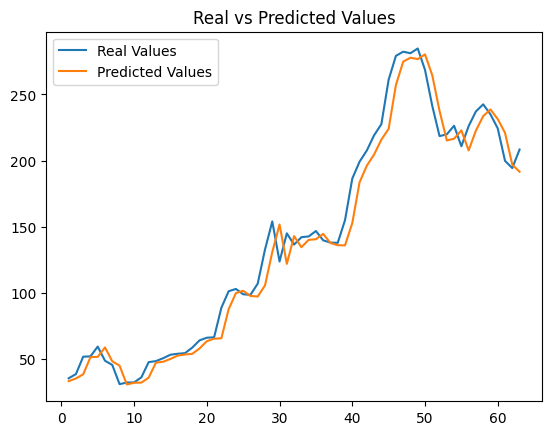

In [261]:
from sklearn.metrics import r2_score

print(X_test.shape)
X_test = X_test.drop(columns=['Tesla Stock Open Price','Tesla Stock Volume','Tesla Stock Adj Close Price','Tesla Stock High','Tesla Stock Low','S&P 500 Variance', 'Tesla Wikipedia Page Views','Nissan Stock Price','Sentiment','Ford Stock Price','GM Stock Price'])
X_test=sm.add_constant(X_test)

y_pred = lrm.predict(X_test)

# Assuming y_test and y_pred are the actual and predicted values, respectively
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

osr2=OSR2(lrm, y_train, X_test, y_test)
print("OSR2 Score:", osr2)

X_test = X_test.drop(columns="const")
print(X_test.head())

mean_absolute_error = np.mean(np.abs(y_test - y_pred))
mean_absolute_error_percentage = mean_absolute_error / np.mean(y_test)
print("Mean Absolute Error:", mean_absolute_error)
print("Mean Absolute Error Percentage:", mean_absolute_error_percentage)

plt.title('Real vs Predicted Values')

plt.plot(y_test,  label= 'Real Values')
plt.plot(y_pred, label = 'Predicted Values')
plt.legend()
plt.show()

## Load Data - Train & Test random split

#### Random split is needed for accuracy of tree-based models since the range of possible stock price values changes over time

In [262]:
tesla_data = pd.read_csv('../full-tesla-data.csv')
tesla_data.drop(columns=['Unnamed: 0'], inplace=True)
tesla_data['Previous Sentiment'] = tesla_data['Sentiment'].shift(1)
tesla_data = tesla_data[1:]
tesla_data = tesla_data.drop(columns=['Tesla Stock Open Price','Tesla Stock Volume','Tesla Stock Adj Close Price','Tesla Stock High','Tesla Stock Low','S&P 500 Variance', 'Tesla Wikipedia Page Views','Nissan Stock Price','Sentiment','Ford Stock Price','GM Stock Price'])
train_tesla_data, test_tesla_data = train_test_split(tesla_data)

X_train = train_tesla_data.drop(columns=['Tesla Stock Close Price'])
X_test = test_tesla_data.drop(columns=['Tesla Stock Close Price'])
y_train = train_tesla_data['Tesla Stock Close Price']
y_test = test_tesla_data['Tesla Stock Close Price']
X_train

,Toyota Stock Price,Previous Sentiment,Previous Week Tesla Stock Close Price
386,115.837500,0.257506,20.943833
12,71.544000,0.255716,1.364133
188,114.965000,0.201424,17.148533
272,100.082499,0.037267,13.391600
135,124.319998,0.223631,6.912133
...,...,...,...
111,91.332499,0.255776,2.298133
464,134.216000,0.071227,123.845833
207,130.982001,0.224036,13.190166
401,123.313998,0.043843,17.215666


## CART Regression
#### To predict next week's stock price

In [263]:
grid_values = {'ccp_alpha': np.linspace(0, 0.001, 51)}

dtr = DecisionTreeRegressor(min_samples_leaf=5, min_samples_split=20, random_state=88)
cv = KFold(n_splits=5,random_state=1,shuffle=True) 
dtr_cv = GridSearchCV(dtr, param_grid=grid_values, scoring='r2', cv=cv, verbose=0)
dtr_cv.fit(X_train, y_train)
test_pred_cart, train_pred_cart = dtr_cv.predict(X_test), dtr_cv.predict(X_train)

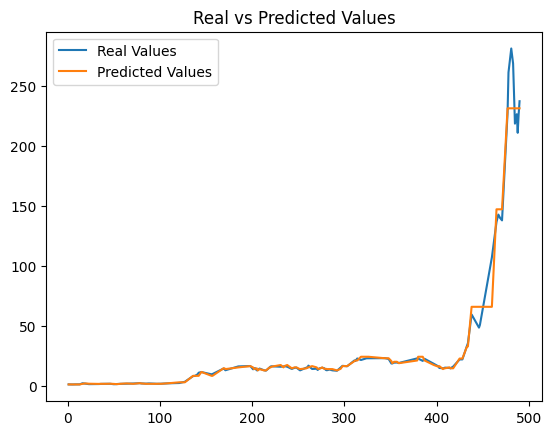

In [264]:
# Create plot to compare real and predicted test stock values

# sort the actual and predicted test data by index 
y_pred_copy = y_test.copy()
for i in range(len(y_pred_copy)):
    y_pred_copy[y_pred_copy.index[i]] = test_pred_cart[i]

plt.title('Real vs Predicted Values')
plt.plot(y_test.sort_index(),  label= 'Real Values')
plt.plot(y_pred_copy.sort_index(), label = 'Predicted Values')
plt.legend()
plt.show()

## RANDOM FOREST Regression
#### To predict next week's stock price

In [265]:
grid_values = {'max_features': np.linspace(1,5,5, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88]} 

rf2 = RandomForestRegressor() 
cv = KFold(n_splits=5,random_state=333,shuffle=True) 
rf_cv = GridSearchCV(rf2, param_grid=grid_values, scoring='r2', cv=cv,verbose=2)
rf_cv.fit(X_train, y_train)
test_pred_rf, train_pred_rf = rf_cv.predict(X_test), rf_cv.predict(X_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=2, min_samples_leaf=5, n_es

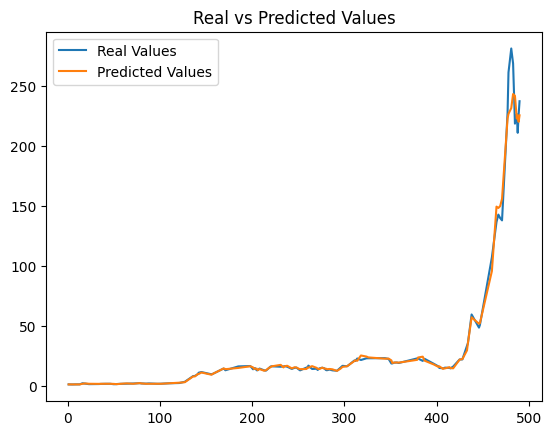

In [266]:
# Create plot to compare real and predicted test stock values

# sort the actual and predicted test data by index 
y_pred_copy = y_test.copy()
for i in range(len(y_pred_copy)):
    y_pred_copy[y_pred_copy.index[i]] = test_pred_rf[i]

plt.title('Real vs Predicted Values')
plt.plot(y_test.sort_index(),  label= 'Real Values')
plt.plot(y_pred_copy.sort_index(), label = 'Predicted Values')
plt.legend()
plt.show()

## GRADIENT BOOSTING Regression
#### To predict next week's stock price

In [267]:
reg = GradientBoostingRegressor(random_state=99)
reg.fit(X_train, y_train)
test_pred_reg, train_pred_reg = reg.predict(X_test), reg.predict(X_train)

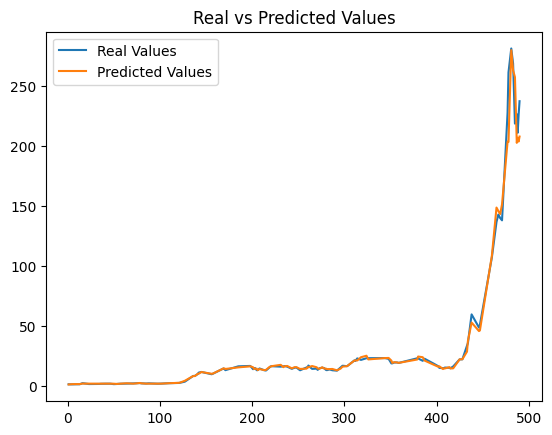

In [268]:
# Create plot to compare real and predicted test stock values

# sort the actual and predicted test data by index 
y_pred_copy = y_test.copy()
for i in range(len(y_pred_copy)):
    y_pred_copy[y_pred_copy.index[i]] = test_pred_reg[i]

plt.title('Real vs Predicted Values')
plt.plot(y_test.sort_index(),  label= 'Real Values')
plt.plot(y_pred_copy.sort_index(), label = 'Predicted Values')
plt.legend()
plt.show()

## Ensemble Model Blending for regression

In [269]:
train = pd.DataFrame({'Tesla_Stock_Price': y_train, 'val_pred_cart': train_pred_cart, 'val_pred_rf': train_pred_rf, 'val_pred_reg': train_pred_reg})
test = pd.DataFrame({'Tesla_Stock_Price': y_test, 'val_pred_cart': test_pred_cart, 'val_pred_rf': test_pred_rf, 'val_pred_reg': test_pred_reg})
ensemble_model = smf.ols(formula='Tesla_Stock_Price ~ val_pred_cart+val_pred_reg+val_pred_rf -1', data=train).fit()
test_pred_ens, train_pred_ens = ensemble_model.predict(test), ensemble_model.predict(train)

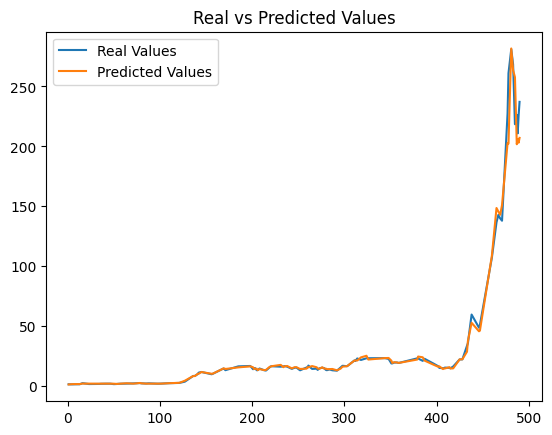

In [270]:
# Create plot to compare real and predicted test stock values

y_pred_copy = test['Tesla_Stock_Price'].copy()
for i in y_pred_copy.index:
    y_pred_copy[i] = test_pred_ens[i]

plt.title('Real vs Predicted Values')
plt.plot(y_test.sort_index(),  label= 'Real Values')
plt.plot(y_pred_copy.sort_index(), label = 'Predicted Values')
plt.legend()
plt.show()

## Model Comparison

In [271]:
comparison_data = {'Linear Regressor': ['{:.3f}'.format(OSR2(lrm, y_train, sm.add_constant(X_test), y_test)),
                                               '{:.4f}'.format(avg_error(lrm.predict(sm.add_constant(X_test)), y_test))],
                    'Decision Tree Regressor': ['{:.3f}'.format(OSR2(dtr_cv, y_train, X_test, y_test)),
                                               '{:.4f}'.format(avg_error(dtr_cv.predict(X_test), y_test))],
                   'Random Forest': ['{:.3f}'.format(OSR2(rf_cv, y_train, X_test, y_test)),
                                     '{:.4f}'.format(avg_error(rf_cv.predict(X_test), y_test))], 
                   'Gradient Boosted Trees': ['{:.3f}'.format(OSR2(reg, y_train, X_test, y_test)),
                                              '{:.4f}'.format(avg_error(reg.predict(X_test), y_test))],
                  'Ensemble Model': ['{:.3f}'.format(OSR2(ensemble_model, y_train, test, y_test)),
                                              '{:.4f}'.format(avg_error(ensemble_model.predict(test), y_test))]}

comparison_table = pd.DataFrame(data=comparison_data, index=['OSR2', 'Average Percent Test Error'])
comparison_table

,Linear Regressor,Decision Tree Regressor,Random Forest,Gradient Boosted Trees,Ensemble Model
OSR2,0.994,0.984,0.988,0.984,0.984
Average Percent Test Error,0.0503,0.0661,0.0524,0.0577,0.0583


## Assemble training & test sets for classification models

#### Create variable "change", representing whether the stock has increased (1) or decreased (0) in the past week

In [272]:
tesla_data = pd.read_csv('../full-tesla-data.csv')
tesla_data.drop(columns=['Unnamed: 0'], inplace=True)
tesla_data['Previous Sentiment'] = tesla_data['Sentiment'].shift(1)
price = tesla_data['Tesla Stock Close Price']

change = [0]
for i in range(1, len(tesla_data)):
    change.append(price[i] > price[i-1])
change = pd.Series([int(val) for val in change])

tesla_data = tesla_data[1:]
tesla_data['change'] = change
train_tesla_data, test_tesla_data = train_test_split(tesla_data)
tesla_data

,Tesla Stock Close Price,Tesla Stock Open Price,Tesla Stock Volume,Tesla Stock Adj Close Price,Tesla Stock High,Tesla Stock Low,S&P 500 Variance,Ford Stock Price,GM Stock Price,Toyota Stock Price,Nissan Stock Price,Tesla Wikipedia Page Views,Sentiment,Previous Sentiment,Previous Week Tesla Stock Close Price,change
1,1.384800,1.398933,9836100,1.384800,1.413600,1.361733,9178.074048,12.914000,34.189999,70.372000,14.840000,1449.400000,0.089603,0.018235,1.372800,1
2,1.388933,1.401200,13199100,1.388933,1.424133,1.354267,435.732436,13.040000,34.189999,72.763998,15.460000,1102.200000,0.140323,0.089603,1.384800,1
3,1.232667,1.256267,12649800,1.232667,1.264800,1.215600,380.825787,12.560000,34.189999,70.756001,15.062000,898.000000,0.040080,0.140323,1.388933,0
4,1.261200,1.255867,7230300,1.261200,1.282000,1.233067,316.106150,12.002000,34.189999,70.690001,15.200000,801.000000,0.188023,0.040080,1.232667,1
5,1.312267,1.303333,8167800,1.312267,1.333600,1.282933,591.345328,11.328000,34.189999,69.030000,14.992000,766.200000,0.168206,0.188023,1.261200,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,234.918665,234.831335,91410360,234.918665,239.967999,230.946664,4137.348271,11.998000,57.904000,152.561996,10.176000,4619.000000,0.204210,-0.042168,242.480667,0
493,224.356668,227.357336,77962860,224.356668,229.717999,221.050668,1138.260281,11.642000,57.556001,152.169998,10.178000,4654.200000,0.219378,0.204210,234.918665,0
494,199.837335,203.438669,113565420,199.837335,207.459335,196.006003,911.892071,11.602000,55.499999,154.380002,9.964000,5280.800000,0.149811,0.219378,224.356668,0
495,194.362003,191.550668,100691280,194.362003,197.497998,189.005331,1386.493858,12.626000,56.049999,160.822000,9.782000,4357.400000,0.196035,0.149811,199.837335,0


In [273]:
X_train = train_tesla_data.drop(columns=['Tesla Stock Close Price', 'change'])
y_train_class = train_tesla_data['change']

X_test = test_tesla_data.drop(columns=['Tesla Stock Close Price', 'change'])
y_test_class = test_tesla_data['change']

features =X_train.columns
X_train

,Tesla Stock Open Price,Tesla Stock Volume,Tesla Stock Adj Close Price,Tesla Stock High,Tesla Stock Low,S&P 500 Variance,Ford Stock Price,GM Stock Price,Toyota Stock Price,Nissan Stock Price,Tesla Wikipedia Page Views,Sentiment,Previous Sentiment,Previous Week Tesla Stock Close Price
103,1.876400,10157700,1.873467,1.894934,1.834400,113.764128,10.2980,24.924000,78.124001,17.4200,1767.60,0.222417,0.244791,1.893067
417,15.011167,85124250,15.045333,15.280833,14.806500,972.735877,9.2450,38.165000,131.722504,12.4300,2674.75,0.181962,0.140228,14.559867
482,286.787335,52825320,284.652661,289.127997,281.463336,1726.559879,11.5140,55.146001,150.776001,11.6520,7753.60,0.139808,0.169297,281.068005
437,51.676267,271176600,52.226400,53.656268,50.590267,1357.345395,8.1500,34.960000,141.413998,10.2300,4934.60,0.205790,0.231126,51.983867
331,23.585200,70800300,23.505467,23.805333,23.252000,497.930067,12.1820,45.371999,123.553999,19.2320,3896.20,0.066146,0.222074,23.542533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,16.008667,122024100,16.178401,16.354667,15.744000,800.342691,8.9780,36.660000,134.770001,12.6440,3579.20,0.179829,0.175849,15.935334
210,13.915600,90447300,13.920400,14.168933,13.655600,1089.142083,16.4160,37.692000,136.873996,20.5020,5175.00,0.212642,0.073233,13.730000
188,17.826500,82985625,18.015500,18.093500,17.729000,902.253758,17.4475,34.747499,114.965000,19.3125,3385.25,0.259970,0.201424,17.148533
432,28.507833,178984875,29.052333,29.292500,28.345166,1945.853283,9.2725,36.535000,141.075001,11.5825,3785.00,0.095571,0.220113,28.429833


## Baseline (predict all weeks stock increase)
#### To predict whether the price increases or decreases next week

In [274]:
def base(data):
    return pd.Series([1] * len(data))

test_pred_base, train_pred_base = base(X_test), base(X_train)
acc_base, TPR_base, FPR_base, PRE_base = get_metrics(test_pred_base, y_test_class)

## CART Classification
#### To predict whether the price increases or decreases next week

In [275]:
grid_values = {'ccp_alpha': np.linspace(0, 0.001, 51)}

dtr = DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=20, random_state=88)
cv = KFold(n_splits=5,random_state=1,shuffle=True) 
dtr_cv = GridSearchCV(dtr, param_grid=grid_values, scoring='r2', cv=cv, verbose=0, error_score='raise')
dtr.fit(X_train, y_train_class)
test_pred_cart, train_pred_cart = dtr.predict(X_test), dtr.predict(X_train)
acc_cart, TPR_cart, FPR_cart, PRE_cart = get_metrics(test_pred_cart, y_test_class)

## Random Forest Classification
#### To predict whether the price increases or decreases next week

In [276]:
grid_values = {'max_features': np.linspace(1,5,5, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88]} 

rf2 = RandomForestClassifier() 
cv = KFold(n_splits=5,random_state=333,shuffle=True) 
rf_cv = GridSearchCV(rf2, param_grid=grid_values, scoring='r2', cv=cv,verbose=2)
rf_cv.fit(X_train, y_train_class)
test_pred_rf, train_pred_rf = rf_cv.predict(X_test), rf_cv.predict(X_train)
acc_rf, TPR_rf, FPR_rf, PRE_rf = get_metrics(test_pred_rf, y_test_class)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=2, min_samples_leaf=5, n_es

## Gradient Boosting Classifier
#### To predict whether the price increases or decreases next week

In [277]:
reg = GradientBoostingClassifier(random_state=99)
reg.fit(X_train, y_train_class)
test_pred_reg, train_pred_reg = reg.predict(X_test), reg.predict(X_train)
acc_reg, TPR_reg, FPR_reg, PRE_reg = get_metrics(test_pred_reg, y_test_class)

## Classification Model Comparison

In [278]:
comparison_data = {'Baseline': ['{:.3f}'.format(acc_base),'{:.4f}'.format(TPR_base), '{:.3f}'.format(FPR_base), '{:.3f}'.format(PRE_base)],
                    'Decision Tree Classifier': ['{:.3f}'.format(acc_cart),'{:.4f}'.format(TPR_cart), '{:.3f}'.format(FPR_cart), '{:.3f}'.format(PRE_cart)],
                   'Random Forest Classifier': ['{:.3f}'.format(acc_rf),'{:.4f}'.format(TPR_rf), '{:.3f}'.format(FPR_rf), '{:.3f}'.format(PRE_rf)], 
                   'Gradient Boosted Classifier': ['{:.3f}'.format(acc_reg),'{:.4f}'.format(TPR_reg), '{:.3f}'.format(FPR_reg), '{:.3f}'.format(PRE_reg)]}

comparison_table = pd.DataFrame(data=comparison_data, index=['Accuracy', 'TPR', 'FPR', 'Precision'])
comparison_table

,Baseline,Decision Tree Classifier,Random Forest Classifier,Gradient Boosted Classifier
Accuracy,0.605,0.548,0.629,0.694
TPR,1.0000,0.6267,0.7600,0.7733
FPR,1.000,0.571,0.571,0.429
Precision,0.605,0.627,0.671,0.734
